In [ ]:
from __future__ import print_function
import sdm as sdmlib
from collections import defaultdict
import random
import string
import time
from math import ceil
from IPython.display import clear_output
import matplotlib.pyplot as plt

#%load_ext line_profiler

empty = ' '
flip_table = string.maketrans('OX', 'XO')

In [ ]:
class Player(object):
    def __init__(self):
        self.stats = defaultdict(int)
    
    def on_invalid_move(self):
        raise Exception('Ops')
    
    def on_finish(self, winner, seq):
        pass
    
    def next_move(self, step, board):
        v = []
        for idx, x in enumerate(board):
            if x == empty:
                v.append(idx)
        return random.choice(v)

In [ ]:
class SmartPlayer(object):
    def __init__(self):
        self.stats = defaultdict(int)
    
    def on_invalid_move(self):
        raise Exception('Ops')
    
    def on_finish(self, winner, seq):
        pass
    
    def next_move(self, step, board):
        v = []
        v_block = []
        #print('='*20)
        #print('board', board)
        for idx, x in enumerate(board):
            if x == empty:
                boardX = board[:idx] + 'X' + board[idx+1:]
                winnerX = check_for_winner(boardX)
                if winnerX == 'X':
                    # Wins the game.
                    return idx

                boardO = board[:idx] + 'O' + board[idx+1:]
                winnerO = check_for_winner(boardO)
                if winnerO == 'O':
                    # Prevents a defeat.
                    v_block.append(idx)
                
                v.append(idx)
        #print('='*20)
        if v_block:
            return v_block[0]
        return random.choice(v)

In [ ]:
class HumanPlayer(object):
    def __init__(self):
        self.stats = defaultdict(int)
    
    def on_invalid_move(self):
        raise Exception('Ops')
    
    def on_finish(self, winner, seq):
        pass
    
    def next_move(self, step, board):
        #clear_output(wait=True)
        while True:
            print_board(board)
            text = raw_input('Entre com a linha/coluna: ')
            if len(text) != 2:
                continue
            si = text[0]
            sj = text[1]
            i = int(si)-1
            j = int(sj)-1
            idx = 3*i+j
            if board[idx] == empty:
                break
        return idx


In [ ]:
class SDMPlayer(object):
    def __init__(self, sdm0, sdm1, bs_to_boards, boards_to_bs):
        self.bs_to_boards = bs_to_boards
        self.boards_to_bs = boards_to_bs
        
        #self.sdm0 = sdm0
        self.sdm1 = sdm1
        
        self.qty_per_action = self.sdm1.bits // 9
        
        self.on_finish = self.on_finish1
        
        self.debug = False
        
        self.reset_stats()
    
    def reset_stats(self):
        self.stats = defaultdict(int)
    
    def on_invalid_move(self):
        raise Exception('Ops')
    
    def board_to_bitstring(self, board):
        bs = self.boards_to_bs.get(board, None)
        if bs is None:
            bs = sdmlib.Bitstring.init_random(self.sdm1.bits)
            self.bs_to_boards[bs] = board
            self.boards_to_bs[board] = bs
            #self.sdm0.write(bs, bs)
        return bs
    
    def bitstring_to_board(self, bs):
        board = self.bs_to_boards.get(bs, None)
        return board
    
    def flip(self, board):
        return board.translate(flip_table)
    
    def on_finish1(self, winner, seq):
        if self.debug:
            print('Learning...')
        
        flip_flag = False
        if winner == 'O':
            flip_flag = True
            winner = winner.translate(flip_table)
        
        for step, (name, action, board_before, board_after) in enumerate(seq):
            board = board_before
            if flip_flag:
                board = self.flip(board)
                name = name.translate(flip_table)
            
            qty = self.qty_per_action
            offset = action*qty
            bs_actions = sdmlib.Bitstring.init_random(self.sdm1.bits)

            if winner is None:
                weight = 1
                for i in range(qty):
                    bs_actions.set_bit(offset+i, 1)
                    
                if name == 'O':
                    board = self.flip(board)

            elif name == winner:
                # Positive learning
                weight = 2
                for i in range(qty):
                    bs_actions.set_bit(offset+i, 1)
                
            else:
                # Negative learning
                weight = 5
                board = self.flip(board)
                for i in range(qty):
                    bs_actions.set_bit(offset+i, 0)

            bs_board = self.board_to_bitstring(board)
            if self.debug:
                print_board(board)
                print(action, weight, self.bs_actions_to_rewards(bs_actions))
            self.sdm1.write(bs_board, bs_actions, weight=weight)
                
    def next_move(self, step, board, debug=False):
        x = self.sdm_move(step, board)
        if x is not None:
            if self.debug:
                print('SDM')
            return x
        if self.debug:
            print('Random')
        return self.random_move(step, board)
    
    def bs_actions_to_rewards(self, bs_actions):
        rewards = []
        bit = 0
        qty = self.qty_per_action
        for idx in range(9):
            x = 0
            for i in range(qty):
                x += bs_actions.get_bit(bit)
                bit += 1
            rewards.append(x)
        return rewards
    
    def sdm_move(self, step, board, debug=False):
        bs_board = self.board_to_bitstring(board)
        bs_actions = self.sdm1.read(bs_board)
        rewards = self.bs_actions_to_rewards(bs_actions)

        if self.debug:
            print_board(board)
            print(rewards)

        for idx, reward in sorted(enumerate(rewards), key=lambda x: x[1], reverse=True):
            if board[idx] == empty:
                if self.debug:
                    print('idx={} reward={}'.format(idx, reward))
                self.stats['sdm'] += 1
                return idx
        return None
    
    def random_move(self, step, board):
        self.stats['random'] += 1
        v = []
        for idx, x in enumerate(board):
            if x == empty:
                v.append(idx)
        return random.choice(v)

In [ ]:
def print_board(board):
    i = 0
    while i < len(board):
        print('|' + board[i:i+3] + '|')
        i += 3
    print('')

def check_all_equal(*args):
    if len(set(args)) == 1 and args[0] != empty:
        return True
    return False
        
def check_for_winner(board):
    for i in range(3):
        if check_all_equal(board[3*i+0], board[3*i+1], board[3*i+2]):
            return board[3*i+0]
        
        if check_all_equal(board[3*0+i], board[3*1+i], board[3*2+i]):
            return board[3*0+i]

    if check_all_equal(board[3*0+0], board[3*1+1], board[3*2+2]):
        return board[3*0+0]
    
    if check_all_equal(board[3*0+2], board[3*1+1], board[3*2+0]):
        return board[3*0+2]
    
    return None

def board_flip(board):
        return board.translate(flip_table)

def play(p1, p2, shuffle=True):
    board = ' '*9
    end = False
    players = [('X', p1), ('O', p2)]
    if shuffle:
        random.shuffle(players)
    index = 0
    step = 0
    sequence = []
    winner = None
    while winner is None and step < 9:
        cur_name, cur_player = players[index]
        
        if cur_name == 'X':
            idx = cur_player.next_move(step, board)
        else:
            idx = cur_player.next_move(step, board_flip(board))
        
        if board[idx] != empty:
            cur_player.on_invalid_move()
        
        new_board = board[:idx] + cur_name + board[idx+1:]
        sequence.append((cur_name, idx, board, new_board))
        board = new_board
        
        winner = check_for_winner(board)
        
        index = (index+1)%2
        step += 1

    return winner, sequence

In [ ]:
def run(pA, pB, n, show=False, debug=False, shuffle=True, learning=True, offset=0):
    wins = defaultdict(int)
    for i in range(n):
        winner, seq = play(pA, pB, shuffle=shuffle)

        wins[winner] += 1

        if not debug:
            clear_output(wait=True)
        else:
            print('')
            
        print('Game #{:5d}: {}  {} {}'.format(i+1+offset, list(wins.items()), list(pA.stats.items()), list(pB.stats.items())))

        if debug:
            for i, (name, action, board_before, board_after) in enumerate(seq):
                print('step={}'.format(i))
                print_board(board_before)
                
        if show:
            print('')
            print_board(seq[-1][3])
            print('')

        if learning:
            pA.on_finish(winner, seq)
            pB.on_finish(winner, seq)
    return wins

In [8]:
bits, radius = 1000, 451
#bits, radius = 256, 103

sample = 1000000
scanner_type = sdmlib.SDM_SCANNER_OPENCL

address_space = sdmlib.AddressSpace.init_random(bits, sample)

#counter0 = sdmlib.Counter.init_zero(bits, sample)
#sdm0 = sdmlib.SDM(address_space, counter0, radius, scanner_type)

counter1 = sdmlib.Counter.init_zero(bits, sample)
sdm11 = sdmlib.SDM(address_space, counter1, radius, scanner_type)

counter2 = sdmlib.Counter.init_zero(bits, sample)
sdm12 = sdmlib.SDM(address_space, counter2, radius, scanner_type)

bs_to_boards = {}
boards_to_bs = {}

In [9]:
scanner_type = sdmlib.SDM_SCANNER_OPENCL
#sdm0 = sdmlib.SDM(address_space, counter0, radius, scanner_type)
sdm11 = sdmlib.SDM(address_space, counter1, radius, scanner_type)
sdm12 = sdmlib.SDM(address_space, counter2, radius, scanner_type)

In [10]:
sdm1 = SDMPlayer(None, sdm11, bs_to_boards, boards_to_bs)
sdm2 = SDMPlayer(None, sdm12, bs_to_boards, boards_to_bs)
rnd = Player()
hum = HumanPlayer()
smt = SmartPlayer()

In [11]:
resultsSmart = []
resultsRandom = []
resultsSDM = []
resultsMixed = []

In [ ]:
sdm1.debug = False
for i in range(30):
    resultsSmart.append(run(sdm1, smt, 100, show=True, offset=100*i, learning=False))
    %time run(sdm1, smt, 100, show=True, offset=100*i, learning=True)

In [ ]:
sdm1.debug = False
for i in range(30):
    resultsRandom.append(run(sdm1, rnd, 100, show=True, offset=100*i, learning=False))
    %time run(sdm1, rnd, 100, show=True, offset=100*i, learning=True)

In [ ]:
sdm1.debug = False
for i in range(20):
    resultsSDM.append(run(sdm1, sdm2, 100, show=True, offset=100*i, learning=False))
    %time run(sdm1, sdm2, 100, show=True, offset=100*i, learning=True)

In [17]:
sdm1.debug = False
for i in range(10):
    other = random.choice([sdm2, smt, rnd])
    resultsMixed.append(run(sdm1, other, 100, show=True, offset=100*i, learning=False))
    %time run(sdm1, other, 100, show=True, offset=100*i, learning=True)

Game # 1000: [('X', 15), (None, 79), ('O', 6)]  [('sdm', 48401)] []

|XOX|
|OXX|
|OXO|


CPU times: user 3.01 s, sys: 608 ms, total: 3.62 s
Wall time: 5.65 s


In [ ]:
%time run(sdm1, sdm2, 500, show=True)

In [ ]:
sdm1.debug = True
run(sdm1, hum, 1, show=True, debug=True, learning=False)

In [ ]:
sdm1.debug = True
run(sdm1, rnd, 1, show=True, debug=True)

In [ ]:
%time run(sdm2, smt, 1000, show=True, learning=True)

In [ ]:
sdmX.next_move(0, ' '*9, debug=True)

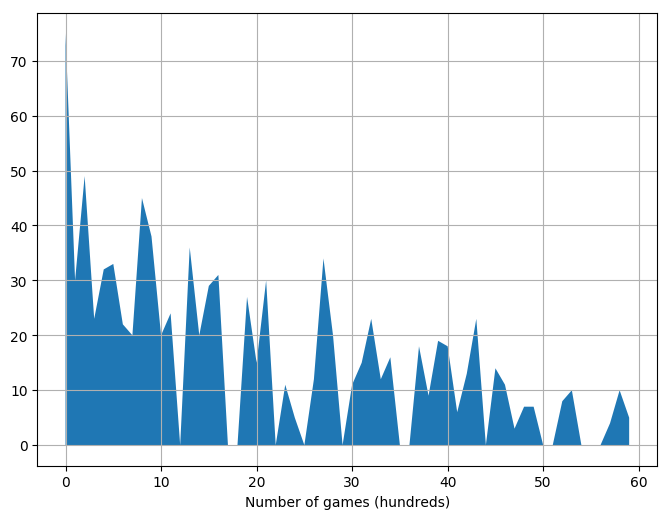

In [19]:
def draw(results):
    import numpy as np

    pos = np.arange(len(results))
    width = 0.35

    plt.figure(figsize=(8, 6), dpi=100)
    winX = [100.0*x['X']/(x['X'] + x['O'] + x[None]) for x in results]
    draw = [100.0*x[None]/(x['X'] + x['O'] + x[None]) for x in results]
    winO = [100.0*x['O']/(x['X'] + x['O'] + x[None]) for x in results]
    #plt.bar(pos, winX, width, color='k')
    #plt.bar(pos, draw, width, bottom=winX, color='b')
    #plt.bar(pos, winO, width)
    #plt.bar(pos+width, [100.0*x['X']/(x['X'] + x['O'] + x[None]) for x in resultsRandom], width, color='y')
    
    plt.stackplot(pos, winO)
    
    #plt.stackplot(pos, winO, draw, winX, labels=['Lose', 'Draw', 'Win'])
    #plt.legend()
 
    plt.grid()
    #plt.ylabel('% of loses')
    plt.xlabel('Number of games (hundreds)');

draw(resultsMixed)

In [ ]:
x = resultsSmart[0]
print(x)

In [ ]:
counter = sdm1.next_move(0, 'X O  O   ')

In [ ]:
counter = sdm11.read_counter(boards_to_bs[' '*9])
bs = counter.to_bitstring(0)
counter_values = [counter.counter[0][i] for i in range(bits)]

In [ ]:
for i, x in enumerate(counter_values):
    if bs.get_bit(i):
        assert(x >= 0)
    else:
        assert(x <= 0)

In [ ]:
for i, x in enumerate(counter_values):
    print('{:4d} {:10d}'.format(i, x))